In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from helpers import *
from Sampler import Sampler
from tqdm import tqdm


def analyse_output_bitstrings(sampler, repeats = 100, title = "Transition Matrix", plot_grid = False, plot_cumulative = False):
    """
    Analyzes the output bitstrings generated by a sampler and computes various metrics 
    related to transition probabilities, BD transitions, and forbidden/self transitions. 
    Optionally, it visualizes the transition matrix and cumulative probability distributions.
    Parameters:
    -----------
    sampler : object
        The sampler object that generates proposals and contains relevant parameters 
        such as `n` (number of nodes) and `q` (number of bits in the bitstring).
    repeats : int, optional
        The number of times to repeat the sampling process for each configuration. 
        Default is 100.
    title : str, optional
        The title for the transition matrix plot. Default is "Transition Matrix".
    plot_grid : bool, optional
        If True, displays the transition matrix plot. If False, the plot is closed. 
        Default is False.
    plot_cumulative : bool, optional
        If True, displays the cumulative probability histogram. If False, the plot is closed. 
        Default is False.
    Returns:
    --------
    weighted_BD_transitions_ignoring_self_transitions : numpy.ndarray
        A flattened array of weighted BD transitions, excluding self-transitions, 
        used for cumulative probability analysis.
    Notes:
    ------
    - The function computes the transition matrix, BD action differences, and 
        forbidden/self transition frequencies.
    - The function supports visualization of the transition matrix and cumulative 
        probability distributions.
    - Forbidden transitions are transitions to configurations that are not valid 
        causal matrices.
    - Self-transitions are transitions where the initial and proposed configurations 
        are the same.
    """
    
    if repeats ==1:
        raise ValueError("Repeats must be greater than 1")
    
    # Generate all of the possibl causal matrices for cardinality n
    _, unique_causal_matrix = get_unique_matrices(sampler.n)
    
    
    # Generate the binary matrix
    mats = [np.frombuffer(mat, dtype=np.int32).reshape( sampler.n,  sampler.n) for mat in  unique_causal_matrix]
    
    print(" ")
    print("Number of unique causal matrices: ", len(mats))
    
    # For each matrix, generate a bitstring
    labels = ["".join(str(i) for i in mat[np.triu_indices( sampler.n, 1)]) for mat in mats]
    
    # Create an array that hold the number of proposals from each causal matrix to each other matrix
    proposal_tracker = np.zeros((2** sampler.q,2** sampler.q))
    
    # Create an array that holds the BD action values for each causal matrix
    BD_action = np.zeros(2** sampler.q)
    
    # Loop through each causal matrix, and create example proposals. 
    # This gives an indication of what binary matrices are proposed from each causal matrix
    for s_pos, s in tqdm(enumerate(labels)):
        
        
        s_prime_list =  sampler.proposal(s, multiple = repeats)
        s_int = int(s, 2)
        
        for s_prime in s_prime_list:
            s_prime_int = int(s_prime, 2)
            proposal_tracker[s_int, s_prime_int] += 1


        BD_action[s_int] =  calculate_action(mats[s_pos])
    
    
    
    BD_sorted_args = np.argsort(BD_action)
    sorted_BD = BD_action[BD_sorted_args]
    # Sort the proposal tracker according to BD action,
    proposal_tracker = proposal_tracker[BD_sorted_args,:]
    proposal_tracker = proposal_tracker[:,BD_sorted_args]
    
    #reorder and normalise
    _proposal_tracker = np.flipud(proposal_tracker)/repeats
    

    cmap = colors.LinearSegmentedColormap.from_list('red_white', ['white', 'red'], N=256)
    
    
    non_zero_bd_index = np.where(sorted_BD != 0)[0][0]
    plt.xticks([])
    plt.yticks([])
    plt.ylim(non_zero_bd_index, 2** sampler.q)
    plt.imshow(_proposal_tracker, extent=[0, 2**sampler.q, 0, 2**sampler.q], cmap=cmap, interpolation='nearest', norm=colors.LogNorm(vmin=1/(2*repeats), vmax=1))
    plt.colorbar(label='Transition Probability', norm=colors.LogNorm(vmin=1/repeats, vmax=1))
    plt.xlabel('Proposed Configuration (s\')')
    plt.ylabel('Initial Configuration (s)')
    plt.title(title)
    
    
    s_int_list = [int(s, 2) for s in labels]
    all_ints = np.arange(0, 2** sampler.q)
    

    all_ints = all_ints[BD_sorted_args]
    
    plt.plot([non_zero_bd_index, 2** sampler.q], [non_zero_bd_index,non_zero_bd_index] ,color='blue', linestyle='--', label='Non-zero BD')
    plt.plot([non_zero_bd_index,non_zero_bd_index], [non_zero_bd_index, 2**sampler.q] ,color='blue', linestyle='--', label='Non-zero BD')


    
    forbidden_count = 0
    for s_pos, s_int in enumerate(all_ints):
        if s_int not in s_int_list:
            for pos_i, i in enumerate(all_ints):
                if proposal_tracker[pos_i, s_pos] > 0:
                    forbidden_count += proposal_tracker[pos_i, s_pos]

            
    print(" ")
    print(" --------------------- ")
    print(title)
    BD_transitions = np.zeros((2** sampler.q,2** sampler.q))
    for i in range(2** sampler.q):
        for j in range(2** sampler.q):
            BD_transitions[i,j] = np.abs(sorted_BD[i] - sorted_BD[j])
    
    total_bd_transition_cost = np.sum((BD_transitions[non_zero_bd_index:,non_zero_bd_index:] * proposal_tracker[non_zero_bd_index:,non_zero_bd_index:]))
    
    total_transitions = np.sum(proposal_tracker)
    
    self_transitions = np.sum(np.diag(proposal_tracker))
    
    Average_BD_transition_cost = total_bd_transition_cost/(total_transitions-forbidden_count-self_transitions)
    frequency_self_transitions = self_transitions/total_transitions
    frequency_forbidden_transitions = forbidden_count/total_transitions
    print(" ")
    print("Average BD transition cost (ignoring forbidden and self transitions): ", Average_BD_transition_cost)
    print(" ")
    print("Frequency of self transitions: ", frequency_self_transitions)
    print("Frequency of forbidden transitions: ", frequency_forbidden_transitions)
    
    if plot_grid:
        plt.show()
    else:
        plt.close()

    
    print(" --------------------- ")
    print(" ")
    
    return Average_BD_transition_cost, frequency_self_transitions, frequency_forbidden_transitions
    
    

/mnt/c/Users/Stuart Ferguson/OneDrive - University of Edinburgh/Documents/PhD/CODE/CST/SamplingCausalSets/SamplingCausalSets/.venv/lib/python3.13/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
# Cardinality of causal set that we are interested in
cardinality = 4

# Number of times to repeat the sampling process per input causal set
repeats = 10000

t = 20

cargs recieved :  {'link_move': True, 'relation_move': True}
------------------------------------------------------------
Starting classical algorithm with the following parameters:
Link move:  True
Relation move:  True


100%|█████████████████████████████████████████████| 1100/1100 [00:00<00:00, 4791.45it/s]


Time taken:  0.23649168014526367  (per step:  0.00021499243649569425 , per sample  0.002364916801452637 )
acceptance rate:  1.0
self move rate:  0.0
invalid proposals rate:  0.0
Using  1  qubits out of  6
------------------------------------------------------------
Starting quantum algorithm with the following parameters:
gamma_TC:  0.99
gamma_BD:  0
gamma_mixing:  0.01
t:  20
 
Number of unique causal matrices:  40


40it [00:02, 13.36it/s]


 
 --------------------- 
1
 
Average BD transition cost (ignoring forbidden and self transitions):  0.03573713819812475
 
Frequency of self transitions:  0.969265
Frequency of forbidden transitions:  7.25e-05


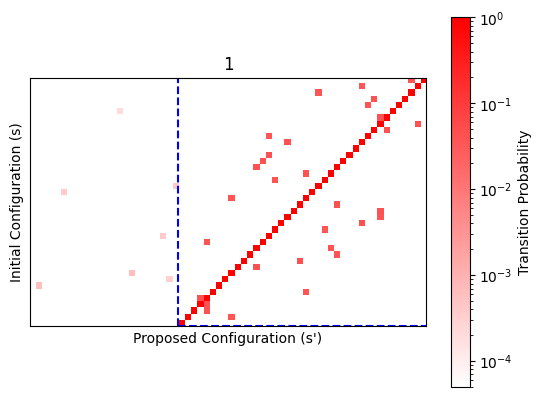

 --------------------- 
 
Using  5  qubits out of  6
------------------------------------------------------------
Starting quantum algorithm with the following parameters:
gamma_TC:  0.99
gamma_BD:  0
gamma_mixing:  0.01
t:  20
 
Number of unique causal matrices:  40


40it [00:03, 11.21it/s]


 
 --------------------- 
5
 
Average BD transition cost (ignoring forbidden and self transitions):  0.03526609478273097
 
Frequency of self transitions:  0.857395
Frequency of forbidden transitions:  0.000385


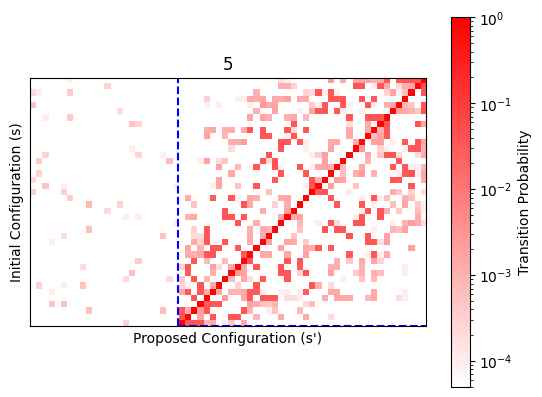

 --------------------- 
 


In [5]:

Csamp = Sampler(cardinality, method="classical",dimension = 4, cargs = {"link_move": True, "relation_move": True})
Csamp.sample_uniform(num_samples = 100, sample_frequency = 10, T_therm = 100)
for num_qubits in [1,5,]:
    Qsamp = Sampler(cardinality, method="quantum",dimension = 4, qargs = {"gammas":[0.99, 0, 0.01], "t":t, "num_qubits": num_qubits, })
    #Qsamp.analyse_TC_Hamiltonian(num_qubits)
    BD_trans_cost, self_trans, forbdden_trans = analyse_output_bitstrings(Qsamp, repeats = repeats, title = str(num_qubits), plot_grid = True, plot_cumulative = False)
    #Qsamp.sample_uniform(num_samples = 100, sample_frequency = 10, T_therm = 100)


In [26]:





# Cardinality of causal set that we are interested in
cardinality = 6

temp = 0.01


num_qubits = [1,3]#1,]

num_chains = 2
num_samples = 300
sample_frequency = 1
T_therm = 0

# Store results for each chain
results = [[] for _ in range(len(num_qubits)+1)]#*(len(num_qubits)+1)
for i in range(num_chains):
    print(f"Starting {i}th round of chains")
    Csamp = Sampler(cardinality, method="classical", dimension=4, cargs={"link_move": True, "relation_move": True}, verbose = True)
    results[0].append(Csamp.sample_BD(T = temp,num_samples=num_samples, sample_frequency=sample_frequency, T_therm=T_therm, observables=["BD_action", "height"]))

    #for j, nq in enumerate(num_qubits):
    for j in range(len(num_qubits)):
        
        if num_qubits[j] == 1:
            gamma_TC = 0.7
        elif num_qubits[j] == 3:
            gamma_TC = 0.9
        elif num_qubits[j] == 5:
            gamma_TC = 0.92
        elif num_qubits[j] == 7:
            gamma_TC = 0.93
        Qsamp = Sampler(cardinality, method="quantum", dimension=4, qargs={"gammas": [gamma_TC, 0, 1-gamma_TC], "t": 20, "num_qubits": num_qubits[j]}, verbose = True)
        results[j+1].append(Qsamp.sample_BD(T = 0.1, num_samples=num_samples, sample_frequency=sample_frequency, T_therm=T_therm, observables=["BD_action", "height"]))

# Compute averages
def average_over_chains(results_list, key):
    arr = np.array([r[key] for r in results_list])
    mean = np.mean(arr, axis=0)
    sem = np.std(arr, axis=0, ddof=1) / np.sqrt(arr.shape[0])
    return mean, sem
sample_index = results[0][0]["sample_index"]  # Assuming all have same indices



avg_bds = []
sem_bds = []
for i in range(len(num_qubits)+1):#len(num_qubits)+1):
    avg_bd, sem_bd = average_over_chains(results[i], "BD_action")
    avg_bds.append(avg_bd)
    sem_bds.append(sem_bd)
avg_bds = np.array(avg_bds)
sem_bds = np.array(sem_bds)



Starting 0th round of chains
cargs recieved :  {'link_move': True, 'relation_move': True}
------------------------------------------------------------
Starting classical algorithm with the following parameters:
Link move:  True
Relation move:  True


 ... (more hidden) ...


Time taken:  0.8379862308502197  (per step:  0.002784007411462524 , per sample  0.0027932874361673993 )
acceptance rate:  0.06312292358803986
self move rate:  0.28903654485049834
forbidden rate:  0.0
Using  1  qubits out of  28
------------------------------------------------------------
Starting quantum algorithm with the following parameters:
gamma_TC:  0.7
gamma_BD:  0
gamma_mixing:  0.30000000000000004
t:  20


 ... (more hidden) ...


Time taken:  11.600425958633423  (per step:  0.038539621125027984 , per sample  0.038668086528778074 )
acceptance rate:  0.016611295681063124
self move rate:  0.9401993355481728
forbidden rate:  0.036544850498338874
Using  3  qubits out of  28
------------------------------------------------------------
Starting quantum algorithm with the following parameters:
gamma_TC:  0.9
gamma_BD:  0
gamma_mixing:  0.09999999999999998
t:  20


 ... (more hidden) ...


Time taken:  16.674519300460815  (per step:  0.055397074087909684 , per sample  0.05558173100153605 )
acceptance rate:  0.6245847176079734
self move rate:  0.11627906976744186
forbidden rate:  0.023255813953488372
Using  5  qubits out of  28
------------------------------------------------------------
Starting quantum algorithm with the following parameters:
gamma_TC:  0.92
gamma_BD:  0
gamma_mixing:  0.07999999999999996
t:  20


 ... (more hidden) ...


Time taken:  59.56914806365967  (per step:  0.1979041463908959 , per sample  0.19856382687886556 )
acceptance rate:  0.6677740863787376
self move rate:  0.0033222591362126247
forbidden rate:  0.036544850498338874
Using  7  qubits out of  28
------------------------------------------------------------
Starting quantum algorithm with the following parameters:
gamma_TC:  0.93
gamma_BD:  0
gamma_mixing:  0.06999999999999995
t:  20


 ... (more hidden) ...


Time taken:  20.935540676116943  (per step:  0.06955329128278054 , per sample  0.06978513558705647 )
acceptance rate:  0.6677740863787376
self move rate:  0.0033222591362126247
forbidden rate:  0.04983388704318937
Starting 1th round of chains
cargs recieved :  {'link_move': True, 'relation_move': True}
------------------------------------------------------------
Starting classical algorithm with the following parameters:
Link move:  True
Relation move:  True


 ... (more hidden) ...


Time taken:  0.3605506420135498  (per step:  0.0011978426644968431 , per sample  0.0012018354733784994 )
acceptance rate:  0.10963455149501661
self move rate:  0.2956810631229236
forbidden rate:  0.0
Using  1  qubits out of  28
------------------------------------------------------------
Starting quantum algorithm with the following parameters:
gamma_TC:  0.7
gamma_BD:  0
gamma_mixing:  0.30000000000000004
t:  20


 ... (more hidden) ...


Time taken:  6.263586521148682  (per step:  0.020809257545344458 , per sample  0.020878621737162272 )
acceptance rate:  0.019933554817275746
self move rate:  0.920265780730897
forbidden rate:  0.046511627906976744
Using  3  qubits out of  28
------------------------------------------------------------
Starting quantum algorithm with the following parameters:
gamma_TC:  0.9
gamma_BD:  0
gamma_mixing:  0.09999999999999998
t:  20


 ... (more hidden) ...


Time taken:  11.114320278167725  (per step:  0.03692465208693596 , per sample  0.03704773426055908 )
acceptance rate:  0.627906976744186
self move rate:  0.12292358803986711
forbidden rate:  0.026578073089700997
Using  5  qubits out of  28
------------------------------------------------------------
Starting quantum algorithm with the following parameters:
gamma_TC:  0.92
gamma_BD:  0
gamma_mixing:  0.07999999999999996
t:  20


 ... (more hidden) ...


Time taken:  24.455172300338745  (per step:  0.08124641960245431 , per sample  0.08151724100112916 )
acceptance rate:  0.7009966777408638
self move rate:  0.019933554817275746
forbidden rate:  0.016611295681063124
Using  7  qubits out of  28
------------------------------------------------------------
Starting quantum algorithm with the following parameters:
gamma_TC:  0.93
gamma_BD:  0
gamma_mixing:  0.06999999999999995
t:  20


 ... (more hidden) ...


Time taken:  19.564905166625977  (per step:  0.06499968493895673 , per sample  0.06521635055541992 )
acceptance rate:  0.6843853820598007
self move rate:  0.009966777408637873
forbidden rate:  0.04318936877076412


Height took  0.03147625923156738  seconds


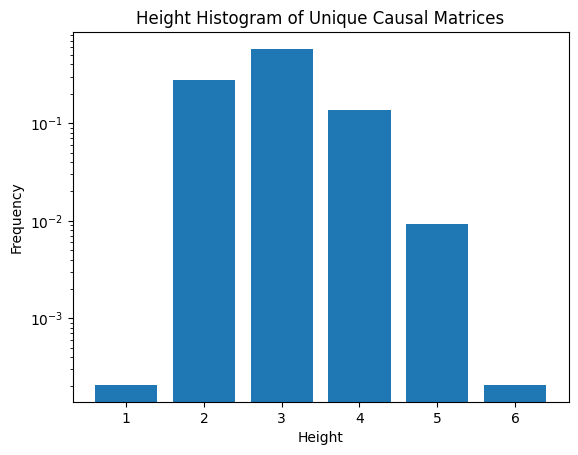

Number of Relations took  0.015665531158447266  seconds


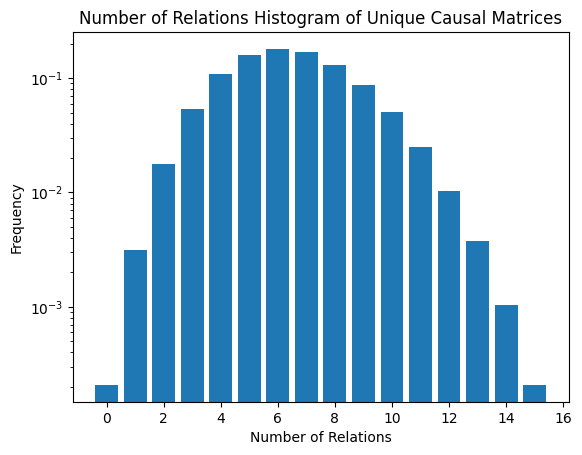

In [21]:
import time
import numpy as np

import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
from helpers import height_histogram, num_relations_histogram,get_unique_matrices

cardinality = 6


unique_matrices, unique_causal_matrices = get_unique_matrices(cardinality)


unique_causal_matrices_ = []
for string in unique_causal_matrices:
    matrix = np.frombuffer(string, dtype=np.int32).reshape((cardinality, cardinality))
    unique_causal_matrices_.append(matrix)

# Convert to a numpy array
unique_causal_matrices = np.array(unique_causal_matrices_)

#print(unique_matrices)
#print(unique_causal_matrices_)


start_time = time.time()
height_bins_exact, height_counts_exact = height_histogram(unique_causal_matrices)
end_time = time.time()
print("Height took ", end_time - start_time, " seconds")

plt.bar(height_bins_exact, height_counts_exact/len(unique_causal_matrices), width=0.8, align='center')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.title('Height Histogram of Unique Causal Matrices')
plt.yscale('log')
plt.show()

start_time = time.time()
nR_bins_exact, nR_counts_exact = num_relations_histogram(unique_causal_matrices)
end_time = time.time()
print("Number of Relations took ", end_time - start_time, " seconds")
plt.bar(nR_bins_exact, nR_counts_exact/len(unique_causal_matrices), width=0.8, align='center')
plt.xlabel('Number of Relations')
plt.ylabel('Frequency')
plt.title('Number of Relations Histogram of Unique Causal Matrices')
plt.yscale('log')
plt.show()


In [2]:

import time
import tqdm.notebook as tqdm
from helpers import height_histogram, num_relations_histogram,get_unique_matrices


#unique_matrices, unique_causal_matrices = get_unique_matrices(7)
#unique_matrices, unique_causal_matrices = get_unique_matrices(8)
#unique_matrices, unique_causal_matrices = get_unique_matrices(9)




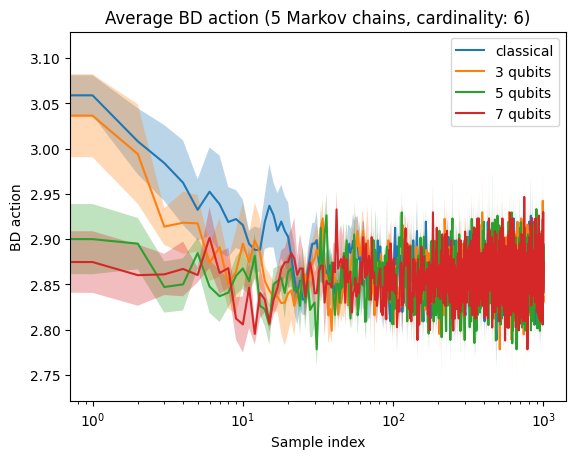

In [34]:

def plot_cumulative_convergence(avg, sem, labels, ylabel="Value", title="Cumulative Convergence", filename=None, exact = None):
    """
    Plots the cumulative average of each chain with optional shaded error region.
    avg: array-like, shape (num_chains, num_samples)
    sem: array-like, shape (num_chains, num_samples), optional
    """
    num_proposals = len(avg)
    x = np.arange(1, avg.shape[1]+1)
    for i in range(num_proposals):
        cum_avg = np.cumsum(avg[i]) / x
        plt.plot(x, cum_avg, label=labels[i])
        if sem is not None:
            cum_sem = np.cumsum(sem[i]) / x
            plt.fill_between(x, cum_avg-cum_sem, cum_avg+cum_sem, alpha=0.3)
    if exact is not None:
        plt.axhline(y=exact, color='r', linestyle='--', label='Exact Value')
    plt.xlabel("Sample index")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xscale('log')
    plt.legend()
    
    if filename:
        plt.savefig(filename)
    plt.show()
    



# Change working directory to 'plots'
def plot_with_shaded_error_multi(x, ys, sems, labels, ylabel, title, filename =None):
    for y, sem, label in zip(ys, sems, labels):
        plt.plot(x, y, label=label)
        plt.fill_between(x, y - sem, y + sem, alpha=0.3)
    plt.xlabel("Sample index")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.xscale('log')
    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()

# Plot BD action with shaded SEM (classical and quantum)

plot_with_shaded_error_multi(
    sample_index,
    avg_bds,
    sem_bds,
    ["classical",]+ [f"{nq} qubits" for nq in num_qubits],
    "BD action", "Average BD action ("+str(num_chains)+" Markov chains, cardinality: " + str(cardinality)+")",
    f"BD_action_avg_{cardinality}.png")



In [ ]:
from helpers import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from Sampler import Sampler
from tqdm import tqdm

num_qubits = [3,5,7]#1,]

T_therm = 0
num_samples = 1000
sample_frequency = 1
num_chains = 5
# Store results for each chain
results = [[] for _ in range(len(num_qubits)+1)]#*(len(num_qubits)+1)
for i in range(num_chains):
    print(f"Starting {i}th round of chains")
    Csamp = Sampler(cardinality, method="classical", dimension=4, cargs={"link_move": True, "relation_move": True}, verbose = False)
    results[0].append(Csamp.sample_uniform(num_samples=num_samples, sample_frequency=sample_frequency, T_therm=T_therm, observables=["BD_action", "height"]))

    #for j, nq in enumerate(num_qubits):
    for j in range(len(num_qubits)):
        
        if num_qubits[j] == 1:
            gamma_TC = 0.7
        elif num_qubits[j] == 3:
            gamma_TC = 0.9
        elif num_qubits[j] == 5:
            gamma_TC = 0.92
        elif num_qubits[j] == 7:
            gamma_TC = 0.93
        Qsamp = Sampler(cardinality, method="quantum", dimension=4, qargs={"gammas": [gamma_TC, 0, 1-gamma_TC], "t": 20, "num_qubits": num_qubits[j]}, verbose = False)
        results[j+1].append(Qsamp.sample_uniform(num_samples=num_samples, sample_frequency=sample_frequency, T_therm=T_therm, observables=["BD_action", "height"]))


Starting 0th round of chains


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.97it/s]


Starting 1th round of chains


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.21it/s]


Starting 2th round of chains


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.04it/s]


Starting 3th round of chains


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 25.81it/s]


Starting 4th round of chains


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:41<00:00, 23.86it/s]


sem_heights: [array([0.        , 0.24494897, 0.50990195, ..., 0.        , 0.2       ,
       0.2       ], shape=(1001,)), array([0.        , 0.4       , 0.4472136 , ..., 0.24494897, 0.24494897,
       0.24494897], shape=(1001,)), array([0.        , 0.2       , 0.31622777, ..., 0.4472136 , 0.24494897,
       0.24494897], shape=(1001,)), array([0.        , 0.2       , 0.4       , ..., 0.37416574, 0.24494897,
       0.48989795], shape=(1001,))]
bins_h_list: [array([1., 2., 3., 4., 5., 6.]), array([1., 2., 3., 4., 5., 6.]), array([1., 2., 3., 4., 5., 6.]), array([1., 2., 3., 4., 5., 6.])]


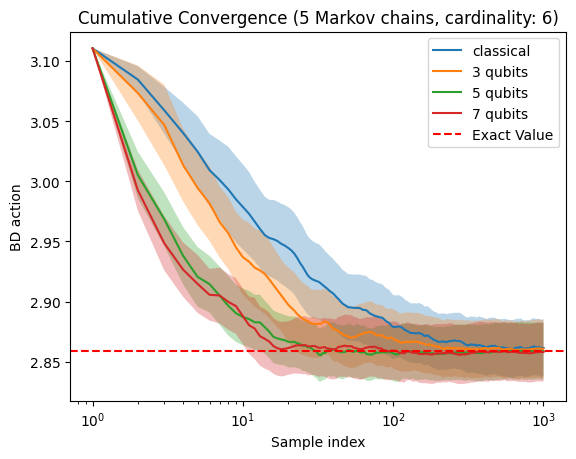

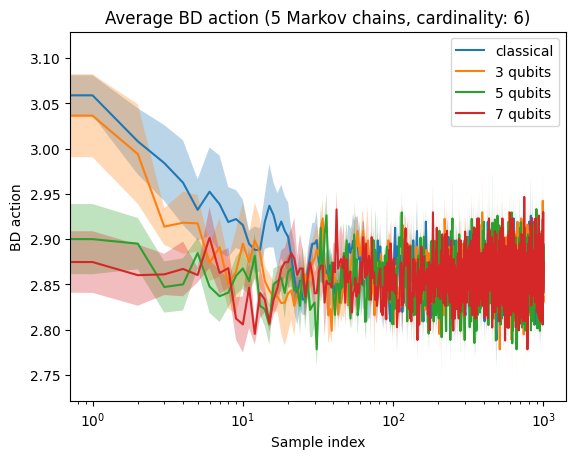

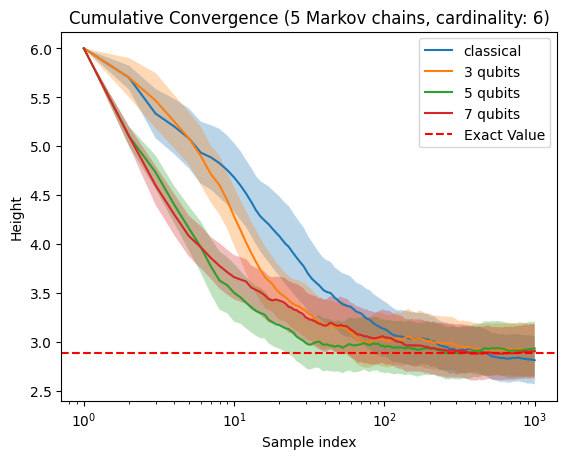

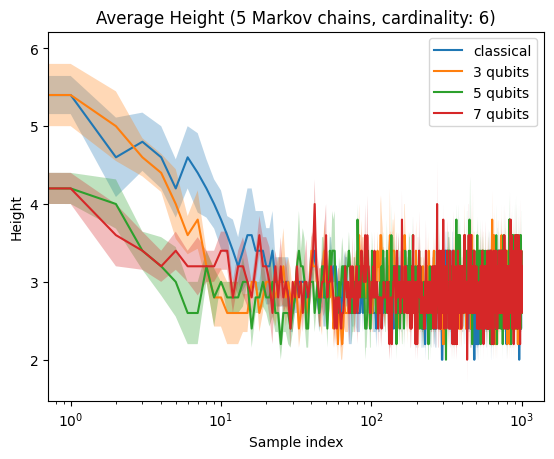

bins_h_list[i]: [1. 2. 3. 4. 5. 6.]
counts_h_list[i]: [0.         0.29490509 0.61138861 0.08391608 0.00739261 0.0023976 ]
sem_h_list[i]: [0.         0.01934918 0.01831744 0.00768647 0.0029057  0.00074758]
bins_h_list[i]: [1. 2. 3. 4. 5. 6.]
counts_h_list[i]: [0.         0.25894106 0.59280719 0.13286713 0.01338661 0.001998  ]
sem_h_list[i]: [0.         0.01434323 0.01507002 0.00653564 0.00185825 0.00044677]
bins_h_list[i]: [1. 2. 3. 4. 5. 6.]
counts_h_list[i]: [1.99800200e-04 2.52547453e-01 5.76823177e-01 1.57842158e-01
 1.09890110e-02 1.59840160e-03]
sem_h_list[i]: [0.0001998  0.00971859 0.00534816 0.00744239 0.00338778 0.0003996 ]
bins_h_list[i]: [1. 2. 3. 4. 5. 6.]
counts_h_list[i]: [3.99600400e-04 2.67732268e-01 5.73226773e-01 1.46653347e-01
 1.05894106e-02 1.39860140e-03]
sem_h_list[i]: [0.0002447  0.01219845 0.01197302 0.00921792 0.00162932 0.0002447 ]


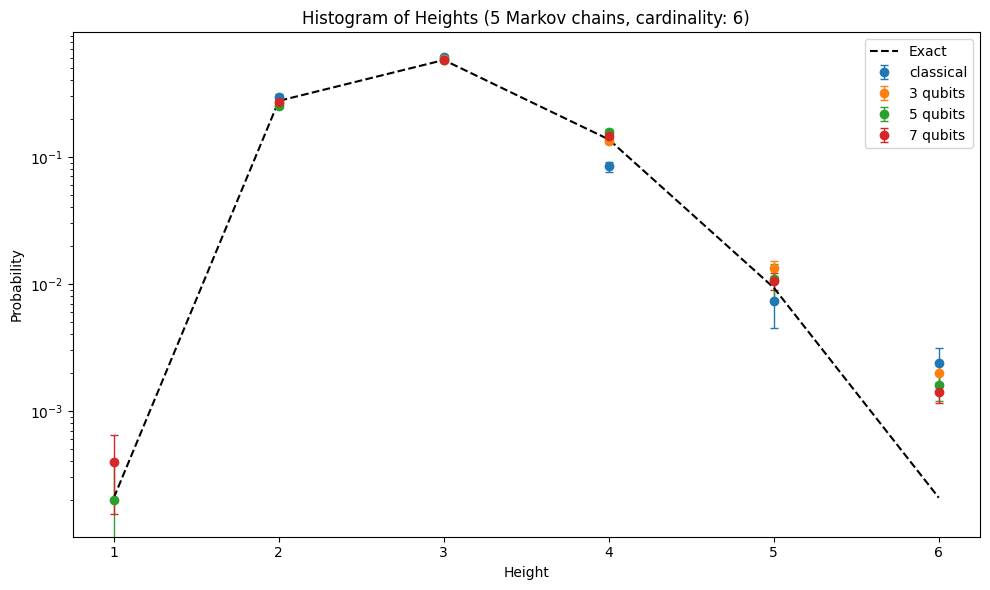

In [35]:

# Compute averages
def average_over_chains(results_list, key):
    arr = np.array([r[key] for r in results_list])
    mean = np.mean(arr, axis=0)
    sem = np.std(arr, axis=0, ddof=1) / np.sqrt(arr.shape[0])
    return mean, sem
sample_index = results[0][0]["sample_index"]  # Assuming all have same indices

def histogram_over_chains(results_list, key, unique_values = None):



    arr = np.array([r[key] for r in results_list])
    if unique_values is not None:
        unique_vals = unique_values
    else:
        # Use np.unique to determine bin edges
        unique_vals = np.unique(arr)
    bins = np.append(unique_vals, unique_vals[-1] + 1) - 0.5
    hist_list = []
    for i in range(arr.shape[0]):
        hist, bin_edges = np.histogram(arr[i], bins=bins, density=True)
        hist_list.append(hist)
    hist_array = np.array(hist_list)
    mean_hist = np.mean(hist_array, axis=0)
    sem_hist = np.std(hist_array, axis=0, ddof=1) / np.sqrt(hist_array.shape[0])
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2
    return mean_hist, sem_hist, bin_mids



avg_bds = []
sem_bds = []
avg_heights = []
sem_heights = []
bins_h_list = []
counts_h_list = []
sem_h_list = []
for i in range(len(num_qubits)+1):#len(num_qubits)+1):
    avg_bd, sem_bd = average_over_chains(results[i], "BD_action")
    avg_bds.append(avg_bd)
    sem_bds.append(sem_bd)

    avg_height, sem_height = average_over_chains(results[i], "heights")
    avg_heights.append(avg_height)
    sem_heights.append(sem_height)

    counts_h, sem_counts_h, bins_h = histogram_over_chains(results[i], "heights", unique_values=np.arange(1, cardinality+1))
    bins_h_list.append(bins_h)
    counts_h_list.append(counts_h)
    sem_h_list.append(sem_counts_h)

avg_bds = np.array(avg_bds)
sem_bds = np.array(sem_bds)
avg_heights = np.array(avg_heights)

print("sem_heights:", sem_heights)
sem_heights = np.array(sem_heights)
print("bins_h_list:", bins_h_list)
bins_h_list = np.array(bins_h_list)
counts_h_list = np.array(counts_h_list)
sem_h_list = np.array(sem_h_list)











exact_action = calculate_average_action_uniform(cardinality = cardinality, causal_matrices = unique_causal_matrices, stdim = 4)

plot_cumulative_convergence(
    avg_bds,
    sem_bds,
    labels = ["classical",]+ [f"{nq} qubits" for nq in num_qubits],
    ylabel="BD action",
    title="Cumulative Convergence ("+str(num_chains)+" Markov chains, cardinality: " + str(cardinality)+")",
    exact = exact_action)

plot_with_shaded_error_multi(
    sample_index,
    avg_bds,
    sem_bds,
    ["classical",]+ [f"{nq} qubits" for nq in num_qubits],
    "BD action", "Average BD action ("+str(num_chains)+" Markov chains, cardinality: " + str(cardinality)+")")





exact_height = calculate_average_height_uniform(causal_matrices = unique_causal_matrices)

plot_cumulative_convergence(
    avg_heights,
    sem_heights,
    labels = ["classical",]+ [f"{nq} qubits" for nq in num_qubits],
    ylabel="Height",
    title="Cumulative Convergence ("+str(num_chains)+" Markov chains, cardinality: " + str(cardinality)+")",
    exact = exact_height)

plot_with_shaded_error_multi(
    sample_index,
    avg_heights,
    sem_heights,
    ["classical",]+ [f"{nq} qubits" for nq in num_qubits],
    "Height", "Average Height ("+str(num_chains)+" Markov chains, cardinality: " + str(cardinality)+")")

plt.figure(figsize=(10,6))
labels = ["classical",]+ [f"{nq} qubits" for nq in num_qubits]
for i in range(len(num_qubits)+1):

    print("bins_h_list[i]:", bins_h_list[i])
    print("counts_h_list[i]:", counts_h_list[i])
    print("sem_h_list[i]:", sem_h_list[i])

    plt.errorbar(
        bins_h_list[i],
        counts_h_list[i],
        yerr=sem_h_list[i],
        label=labels[i],
        fmt='o-', capsize=3,
        linewidth=0,
        elinewidth=1
    )
plt.plot(height_bins_exact, height_counts_exact/len(unique_causal_matrices), 'k--', label='Exact')
plt.xlabel("Height")
plt.ylabel("Probability")
plt.title("Histogram of Heights (" + str(num_chains) + " Markov chains, cardinality: " + str(cardinality) + ")")
plt.legend()
plt.yscale('log')
plt.tight_layout()
plt.show()

In [42]:
# Longruns


from helpers import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from Sampler import Sampler
from tqdm import tqdm


cardinality = 20
num_qubits = [3,5,7]#1,]

T_therm = 0
num_samples = 100
sample_frequency = 1
num_chains = 5
# Store results for each chain
results = [[] for _ in range(len(num_qubits)+1)]#*(len(num_qubits)+1)
for i in range(num_chains):
    print(f"Starting {i}th round of chains")
    Csamp = Sampler(cardinality, method="classical", dimension=4, cargs={"link_move": True, "relation_move": True}, verbose = False)
    results[0].append(Csamp.sample_uniform(num_samples=num_samples, sample_frequency=sample_frequency, T_therm=T_therm))#, observables=["BD_action", "height",]))

    #for j, nq in enumerate(num_qubits):
    for j in range(len(num_qubits)):
        
        if num_qubits[j] == 1:
            gamma_TC = 0.7
        elif num_qubits[j] == 3:
            gamma_TC = 0.9
        elif num_qubits[j] == 5:
            gamma_TC = 0.92
        elif num_qubits[j] == 7:
            gamma_TC = 0.93
        elif num_qubits[j] > 7:
            gamma_TC = 0.95
        Qsamp = Sampler(cardinality, method="quantum", dimension=4, qargs={"gammas": [gamma_TC, 0, 1-gamma_TC], "t": 20, "num_qubits": num_qubits[j]}, verbose = False)
        results[j+1].append(Qsamp.sample_uniform(num_samples=num_samples, sample_frequency=sample_frequency, T_therm=T_therm))#, observables=["BD_action", "height"]))


Starting 0th round of chains


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.43it/s]


Starting 1th round of chains


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.84it/s]


Starting 2th round of chains


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.76it/s]


Starting 3th round of chains


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.64it/s]


Starting 4th round of chains


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.84it/s]


sem_heights: [array([0.        , 0.        , 0.2       , 0.2       , 0.2       ,
       0.24494897, 0.24494897, 0.24494897, 1.71464282, 1.71464282,
       1.71464282, 1.71464282, 1.71464282, 1.71464282, 1.71464282,
       1.71464282, 1.71464282, 1.91311265, 1.91311265, 1.86010752,
       1.82756669, 1.98494332, 1.98494332, 1.98494332, 1.98494332,
       1.92353841, 1.88148877, 1.88148877, 1.88148877, 1.88148877,
       1.88148877, 1.88148877, 1.88148877, 1.88148877, 1.88148877,
       1.88148877, 1.88148877, 1.88148877, 1.88148877, 1.88148877,
       1.88148877, 1.88148877, 1.83303028, 1.83303028, 1.83303028,
       1.83303028, 1.83303028, 1.83303028, 1.83303028, 1.83303028,
       1.83303028, 1.83303028, 1.83303028, 1.83303028, 1.83303028,
       1.83303028, 1.80554701, 1.80554701, 1.68522995, 2.05912603,
       2.05912603, 2.05912603, 2.05912603, 2.05912603, 2.05912603,
       2.05912603, 2.05912603, 2.05912603, 2.05912603, 2.05912603,
       2.22710575, 2.11187121, 2.03469899, 2.034

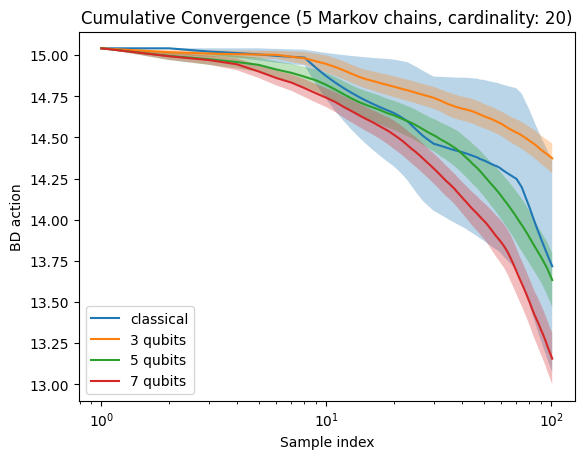

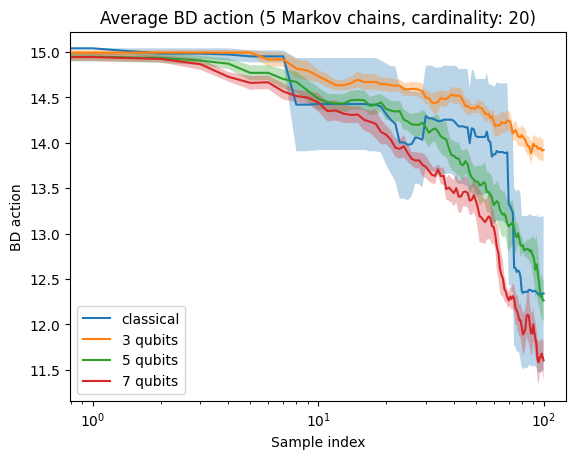

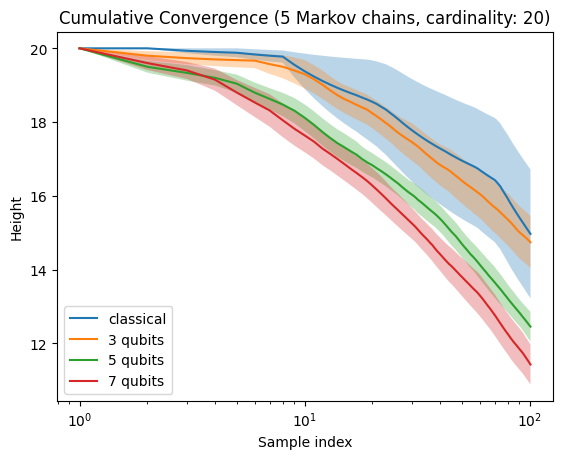

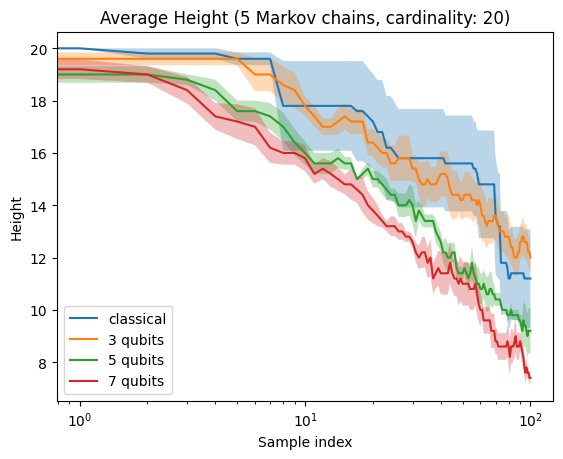

bins_h_list[i]: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]
counts_h_list[i]: [0.         0.         0.         0.         0.         0.
 0.05940594 0.06732673 0.08514851 0.06930693 0.01782178 0.
 0.         0.04158416 0.1009901  0.04356436 0.17227723 0.05544554
 0.1049505  0.18217822]
sem_h_list[i]: [0.         0.         0.         0.         0.         0.
 0.04416774 0.04170186 0.073401   0.05989894 0.01782178 0.
 0.         0.04158416 0.1009901  0.02828288 0.07054065 0.02930425
 0.04253971 0.10206187]
bins_h_list[i]: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]
counts_h_list[i]: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.05940594 0.05742574 0.05148515
 0.13465347 0.20792079 0.14257426 0.0990099  0.1009901  0.04554455
 0.04158416 0.05940594]
sem_h_list[i]: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.059405

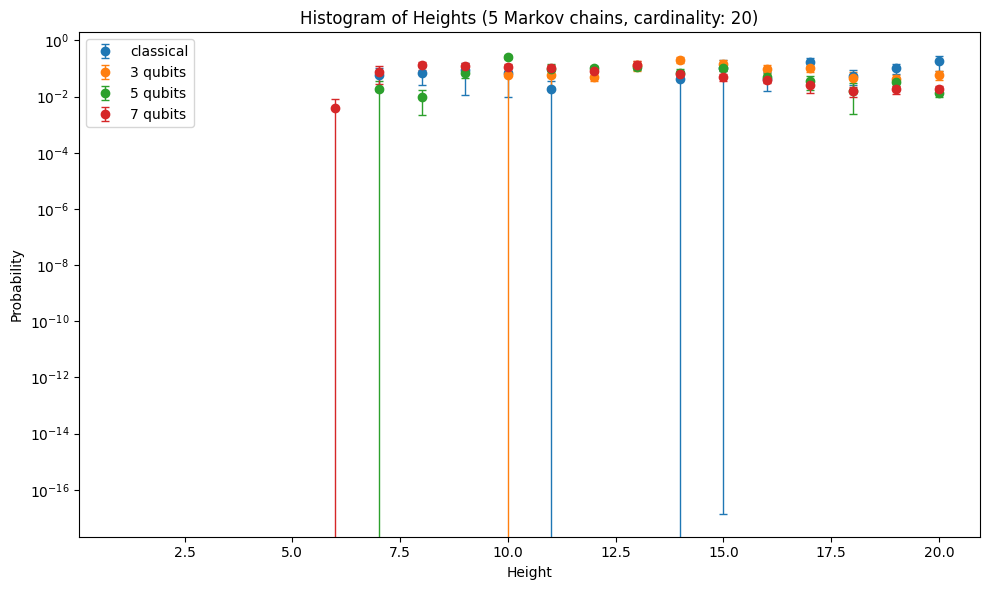

In [44]:

# Compute averages
def average_over_chains(results_list, key):
    arr = np.array([r[key] for r in results_list])
    mean = np.mean(arr, axis=0)
    sem = np.std(arr, axis=0, ddof=1) / np.sqrt(arr.shape[0])
    return mean, sem
sample_index = results[0][0]["sample_index"]  # Assuming all have same indices

def histogram_over_chains(results_list, key, unique_values = None):



    arr = np.array([r[key] for r in results_list])
    if unique_values is not None:
        unique_vals = unique_values
    else:
        # Use np.unique to determine bin edges
        unique_vals = np.unique(arr)
    bins = np.append(unique_vals, unique_vals[-1] + 1) - 0.5
    hist_list = []
    for i in range(arr.shape[0]):
        hist, bin_edges = np.histogram(arr[i], bins=bins, density=True)
        hist_list.append(hist)
    hist_array = np.array(hist_list)
    mean_hist = np.mean(hist_array, axis=0)
    sem_hist = np.std(hist_array, axis=0, ddof=1) / np.sqrt(hist_array.shape[0])
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2
    return mean_hist, sem_hist, bin_mids



avg_bds = []
sem_bds = []
avg_heights = []
sem_heights = []
bins_h_list = []
counts_h_list = []
sem_h_list = []
for i in range(len(num_qubits)+1):#len(num_qubits)+1):
    avg_bd, sem_bd = average_over_chains(results[i], "BD_action")
    avg_bds.append(avg_bd)
    sem_bds.append(sem_bd)

    avg_height, sem_height = average_over_chains(results[i], "heights")
    avg_heights.append(avg_height)
    sem_heights.append(sem_height)

    counts_h, sem_counts_h, bins_h = histogram_over_chains(results[i], "heights", unique_values=np.arange(1, cardinality+1))
    bins_h_list.append(bins_h)
    counts_h_list.append(counts_h)
    sem_h_list.append(sem_counts_h)

avg_bds = np.array(avg_bds)
sem_bds = np.array(sem_bds)
avg_heights = np.array(avg_heights)

print("sem_heights:", sem_heights)
sem_heights = np.array(sem_heights)
print("bins_h_list:", bins_h_list)
bins_h_list = np.array(bins_h_list)
counts_h_list = np.array(counts_h_list)
sem_h_list = np.array(sem_h_list)











exact_action = calculate_average_action_uniform(cardinality = cardinality, causal_matrices = unique_causal_matrices, stdim = 4)

plot_cumulative_convergence(
    avg_bds,
    sem_bds,
    labels = ["classical",]+ [f"{nq} qubits" for nq in num_qubits],
    ylabel="BD action",
    title="Cumulative Convergence ("+str(num_chains)+" Markov chains, cardinality: " + str(cardinality)+")")
#exact = exact_action)

plot_with_shaded_error_multi(
    sample_index,
    avg_bds,
    sem_bds,
    ["classical",]+ [f"{nq} qubits" for nq in num_qubits],
    "BD action", "Average BD action ("+str(num_chains)+" Markov chains, cardinality: " + str(cardinality)+")")





exact_height = calculate_average_height_uniform(causal_matrices = unique_causal_matrices)

plot_cumulative_convergence(
    avg_heights,
    sem_heights,
    labels = ["classical",]+ [f"{nq} qubits" for nq in num_qubits],
    ylabel="Height",
    title="Cumulative Convergence ("+str(num_chains)+" Markov chains, cardinality: " + str(cardinality)+")")
    #exact = exact_height)

plot_with_shaded_error_multi(
    sample_index,
    avg_heights,
    sem_heights,
    ["classical",]+ [f"{nq} qubits" for nq in num_qubits],
    "Height", "Average Height ("+str(num_chains)+" Markov chains, cardinality: " + str(cardinality)+")")

plt.figure(figsize=(10,6))
labels = ["classical",]+ [f"{nq} qubits" for nq in num_qubits]
for i in range(len(num_qubits)+1):

    print("bins_h_list[i]:", bins_h_list[i])
    print("counts_h_list[i]:", counts_h_list[i])
    print("sem_h_list[i]:", sem_h_list[i])

    plt.errorbar(
        bins_h_list[i],
        counts_h_list[i],
        yerr=sem_h_list[i],
        label=labels[i],
        fmt='o-', capsize=3,
        linewidth=0,
        elinewidth=1
    )
#plt.plot(height_bins_exact, height_counts_exact/len(unique_causal_matrices), 'k--', label='Exact')
plt.xlabel("Height")
plt.ylabel("Probability")
plt.title("Histogram of Heights (" + str(num_chains) + " Markov chains, cardinality: " + str(cardinality) + ")")
plt.legend()
plt.yscale('log')
plt.tight_layout()
plt.show()